### Importing Libaries

In [631]:
# Data analyis/math
import pandas as pd
import re
import random
import numpy as np
import warnings

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## Passenger Object

In [632]:
class Passenger:

    def __init__(self, attributeList):
        """
        if data is missing on attribute list -> call missing data fucntions
        """
        if len(attributeList) == 8:
            self.Survived = attributeList[0]
            self.Pclass = attributeList[1]
            self.Sex = attributeList[2]
            self.Age = attributeList[3]
            self.SibSp = attributeList[4]
            self.ParCh = attributeList[5]
            self.Fare = attributeList[6]
            self.Embarked = attributeList[7]
        else:
            self.Pclass = attributeList[0]
            self.Sex = attributeList[1]
            self.Age = attributeList[2]
            self.SibSp = attributeList[3]
            self.ParCh = attributeList[4]
            self.Fare = attributeList[5]
            self.Embarked = attributeList[6]
        
    def getSurvived(self):
        return self.Survived
    
    def getPclass(self):
        return self.Pclass
    
    def getSex(self):
        return self.Sex
    
    def getAge(self):
        return self.Age
    
    def getSibSp(self):
        return self.SibSp
    
    def getParCh(self):
        return self.ParCh
    
    def getFare(self):
        return self.Fare
    
    def getEmbarked(self):
        return self.Embarked
    
    def __repr__(self):
        return f'Passenger is a {self.Age} year old {self.Sex}'

## Cleaning Data

In [633]:
# Importing data
trainData = pd.read_csv('train.csv')
testData = pd.read_csv('test.csv')
testAnswers = pd.read_csv('gender_submission.csv')

# Cleaning data

# Removing unnecessary columns

unnessaryColumns = ['PassengerId', 'Name', 'Ticket', 'Cabin']

trainData = trainData.drop(unnessaryColumns, axis=1)
testData = testData.drop(unnessaryColumns, axis=1)

# Strip whitespace, make lowercase, remove special characters
trainData = trainData.applymap(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x.strip().lower()) if isinstance(x, str) else x)
testData = testData.applymap(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x.strip().lower()) if isinstance(x, str) else x)


# Make Numeric

# Sex: male = 1, female = 0
trainData['Sex'] = trainData['Sex'].map({'male': 1, 'female': 2})
testData['Sex'] = testData['Sex'].map({'male': 1, 'female': 2})

# Embarked: s = 0, c = 1, q = 2
trainData['Embarked'] = trainData['Embarked'].map({'s': 1, 'c': 2, 'q': 3})
testData['Embarked'] = testData['Embarked'].map({'s': 1, 'c': 2, 'q': 3})

## Helper Methods

In [634]:
def accuracy(preds, data, columnName):
    """
    takes a list of predictions (ones and zeros) and 
    calculates overlap with the 'survived column' of given data
    """
    correctCount = 0
    for index, row in data.iterrows():
        if data.iloc[index][columnName] == preds[index]:
            correctCount += 1
    
    return ((correctCount)/len(preds)) * 100

def mode(predList):
    aliveCount = 0
    deathCount = 0
    for i, survived in enumerate(predList):
        if predList[i] == 1:
            aliveCount += 1
        else:
            deathCount += 1
    if aliveCount > deathCount:
        return 1
    else:
        return 0
    
def distFunc(passenger1, passenger2, distNorm = 'L1', ignoreAge = False):
    dist = 0
    for i, attribute in enumerate(attributes):
        if ignoreAge:
            if attribute != 'Age':
                match distNorm:
                    case 'L1':
                        dist += abs(getAttribute(passenger1, attribute) - getAttribute(passenger2, attribute))
                    case 'L2':
                        diff = getAttribute(passenger1, attribute) - getAttribute(passenger2, attribute)
                        dist += (diff ** 2)
        else:
            match distNorm:
                case 'L1':
                    dist += abs(getAttribute(passenger1, attribute) - getAttribute(passenger2, attribute))
                case 'L2':
                    diff = getAttribute(passenger1, attribute) - getAttribute(passenger2, attribute)
                    dist += (diff ** 2)


    return (dist ** 0.5)

## Fill Missing Data

In [635]:
def fill_missing_ages(df, k=11):
    """
    finds k closest passengers to a passenger with missing age and fills in their age with the mean
    of those passengers
    """
    missing_ages_passengers = df[df['Age'].isnull()]
    
    for index, row in missing_ages_passengers.iterrows():
        distances = []
        for _, other_row in df.dropna().iterrows():
            dist = distFunc(Passenger(row.values.tolist()), Passenger(other_row.values.tolist()), ignoreAge = True)
            distances.append((other_row.name, dist))
        
        closestIndices = sorted(distances, key=lambda x: x[1])[:k]
        closestPassengerAges = [df.loc[idx, 'Age'] for idx, _ in closestIndices]
        
        meanAge = sum(closestPassengerAges) / k
        
        df.at[index, 'Age'] = meanAge
    
    return df

# Call the function to fill missing ages
trainData = fill_missing_ages(trainData)
testData = fill_missing_ages(testData)

# Fill in other few missing values with means
trainData = trainData.fillna(trainData.mean())

testData = testData.fillna(trainData.mean())


## Visualize Data

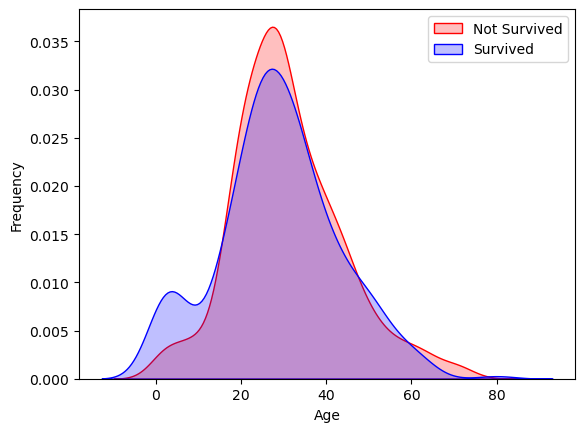

In [636]:
# Age
g = sns.kdeplot(trainData["Age"][(trainData["Survived"] == 0) & (trainData["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(trainData["Age"][(trainData["Survived"] == 1) & (trainData["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

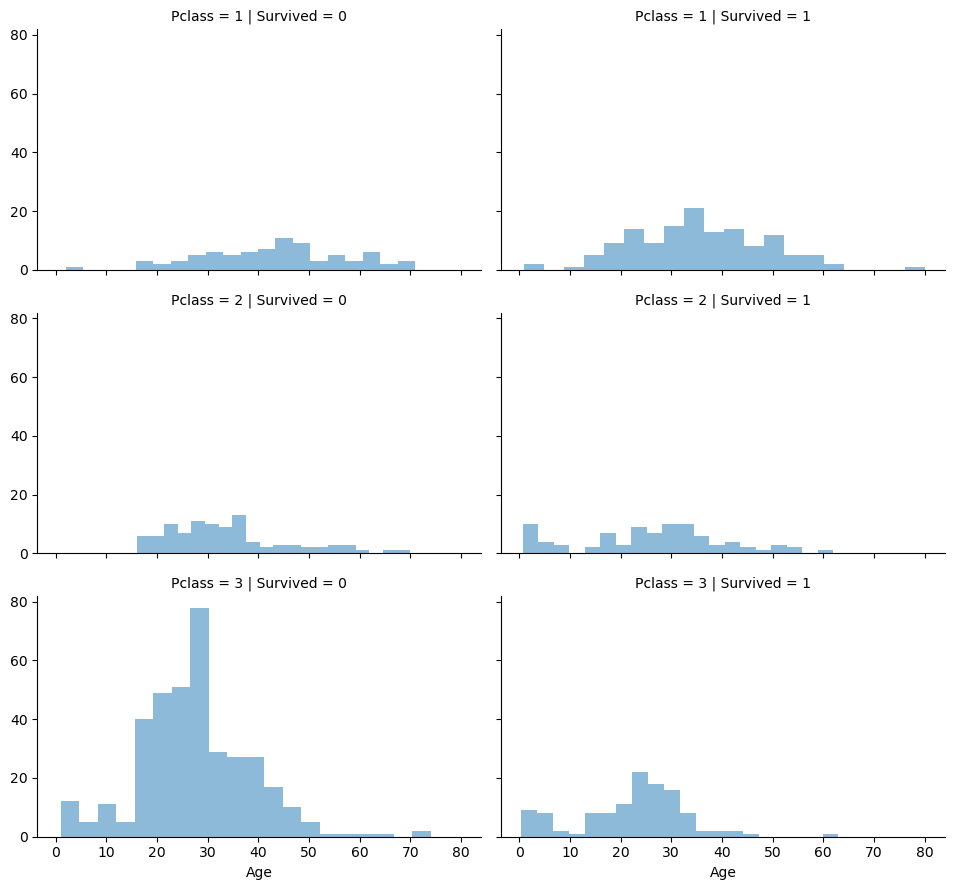

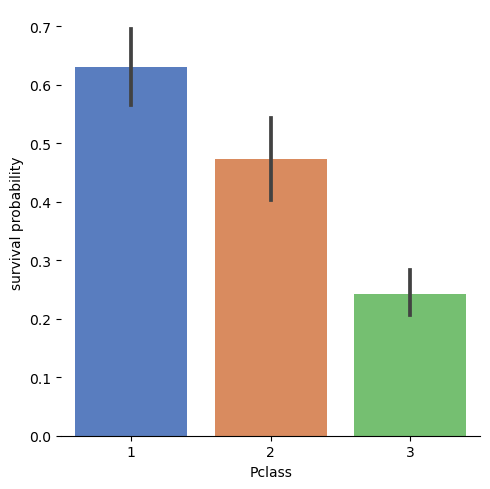

In [637]:
# Pclass
grid = sns.FacetGrid(trainData, col='Survived', row='Pclass', aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

g = sns.catplot(x="Pclass",y="Survived",data=trainData,kind="bar", 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

,Survived
Sex,
1,0.188908
2,0.742038


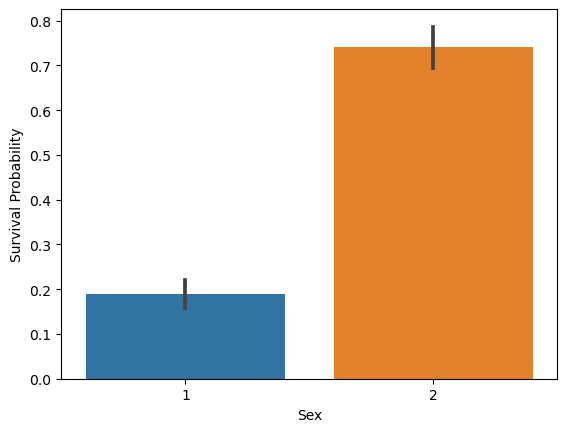

In [638]:
# Sex
gr = sns.barplot(x="Sex",y="Survived",data=trainData)
gr = gr.set_ylabel("Survival Probability")

trainData[["Sex","Survived"]].groupby('Sex').mean()

## Decision Tree

In [639]:
def decisionTree(passenger):
    """
    returns survivor prediction for given passenger
    1 if survived, 0 if died
    """
    pClass = passenger.getPclass()
    sex = passenger.getSex() # male: 1, female: 2
    age = passenger.getAge()
    sibSp = passenger.getSibSp()
    parCh = passenger.getParCh()
    fare = passenger.getFare()
    embarked = passenger.getEmbarked()
    
    if sex == 1: # Male
        if age > 12: # Male, older than 12
            if pClass == 2 or pClass == 3: # Male, older than 12, in 2nd or 3rd class
                return 0
            else:
                if age > 35: # Male, older than 35, first class
                    return 0
                else:
                    if age < 30:
                        return 0 # died if male, first class is less than 30
                    else:
                        return 1
        elif sibSp < 2:
            return 1
        else: 
            return 0
        return 0
    else: # Female
        match pClass:
            case 1: # First class females
                if random.randint(0, 82) < 79: # 79 out of 82 people survived
                    return 1
                else: 
                    return 0
            case 2: # Second Class females
                if age <= 23: # Second class females over 23
                    return 1
                if parCh >= 2: # Second class females with over 1 parent/spouse
                    return 1
                
                if random.randint(0, 41) < 36: # 36 out of 41 people survived
                    return 1
                else: 
                    return 0
                
                
            case 3:
                match embarked:
                    case 1: # Southampton
                        match sibSp:
                            case 0:
                                if age < 28:
                                    return 1
                                else:
                                    if random.randint(0, 11) < 3: # 3 out of 11 people survived
                                        return 1
                                    else: 
                                        return 0
                            case 1:
                                if random.randint(0, 23) < 8: # 8 out of 23 people survived
                                    return 1
                                else: 
                                    return 0
                            case _:
                                if random.randint(0, 19) < 3: # 3 out of 19 people survived
                                    return 1
                                else: 
                                    return 0
                    case 2: # Cherbourg
                        if age <= 14:
                            return 1
                        
                        if random.randint(0, 5) < 1: # 1 out of 5 people survived
                            return 1
                        else: 
                            return 0
                        
                    case 3: # Queenstown
                        if age >= 23:
                            return 0
                        
                        if random.randint(0, 7) < 5: # 5 out of 7 people survived
                            return 1
                        else: 
                            return 0
                        
        return 1       

### Sci Kit Learn Decision Tree

In [640]:
# Prep
X_train = trainData.drop("Survived", axis=1)
Y_train = trainData["Survived"]
X_test  = testData.copy()

# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)

SciKitLearnDecTreeAcc = round(accuracy(Y_pred, testAnswers, "Survived"), 2)

## Logistic Regression

In [641]:
weights = [-5.484844451041736, -7.605450602165511, -0.5726490004995397, 
           27.04005963262653, -0.02427268329054242, -1.2369238305370738, -1.1267246031054758, 
           0.1612078218380119] # first value is bias, last 7 are attributes 


attributes = ['Pclass', 'Embarked', 'Sex', 'Age', 'SibSp', 'ParCh', 'Fare']

ALPHA = 1

def getAttribute(passenger, attribute):
    match attribute:
        case 'Age':
            return passenger.getAge()
        case 'Sex':
            return passenger.getSex()
        case 'Fare':
            return passenger.getFare()
        case 'Embarked':
            return passenger.getEmbarked()
        case 'SibSp':
            return passenger.getSibSp()
        case 'ParCh':
            return passenger.getParCh()
        case 'Pclass':
            return passenger.getPclass()
            

def logRegWeights():
    passengers = trainData.copy()
    global weights
    loss = 100.0
    while loss > 0.19:
#         print(weights)
#         print(loss)
        loss = 0.0
        weight_changes = np.zeros(len(attributes) + 1)
        for i in range(len(passengers)):
            predicted = weights[0]
            for j in range(len(attributes)):
                predicted += weights[j + 1] * getAttribute(Passenger(passengers.iloc[i].tolist()), attributes[j])
            sigmoid = 1 / (1 + np.exp(-predicted))
            difference = (passengers.iloc[i]['Survived'] - sigmoid)
            loss += ((difference ** 2) / len(passengers)) # squared loss
            weight_changes[0] = weights[0] + ALPHA * difference * sigmoid * (1 - sigmoid) # bias
            
            for j in range(len(attributes)):
                value = weights[j + 1] + ALPHA * difference * sigmoid * (1 - sigmoid) * getAttribute(Passenger(passengers.iloc[i].tolist()), attributes[j])
                weight_changes[j + 1] += value / len(passengers)
        weights = weight_changes
        
def logRegSurvived(passenger):
    predicted = 0
    predicted += weights[0]
    for i in range(len(attributes)):
        predicted += weights[i + 1] * getAttribute(passenger, attributes[i])
    sigmoid = 1 / (1 + np.exp(-predicted));
    if sigmoid > 0.5:
        return 1
    else:
        return 0

### Sci Kit Learn Logistic Regression

In [642]:
warnings.filterwarnings('ignore') 

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)

SciKitLearnLogRegAcc = round(accuracy(Y_pred, testAnswers, "Survived"), 2)

## KNN

In [643]:
attributes = ['Pclass', 'Embarked', 'Sex', 'Age', 'SibSp', 'ParCh', 'Fare']


def survivedMode(neighborsList):
    """
    takes a list of tuples (with passengers and distances) and returns mode of survived
    """
    aliveCount = 0
    deathCount = 0
    for i, survived in enumerate(neighborsList):
        if neighborsList[i][0].getSurvived() == 1:
            aliveCount += 1
        else:
            deathCount += 1
    if aliveCount > deathCount:
        return 1
    else:
        return 0 # Also return death in a tie because more passengers died than survived
    
    
def knn(passenger, k):
    neighbors = np.zeros(k).tolist()
    fillerTup = ('xxx', float('inf'))
    for i in range(k):
        neighbors[i] = fillerTup
        
        
    for index, row in trainData.iterrows():
        currPassenger = Passenger(row.tolist())
        currDist = distFunc(passenger, currPassenger, 'L1')
        if currDist < neighbors[k-1][1]:
            neighbors[k-1] = (currPassenger, currDist)
        neighbors = sorted(neighbors, key = lambda x: x[1]) 
        
    return survivedMode(neighbors) 

### Sci Kit Learn KNN

In [644]:
knnModel = KNeighborsClassifier(n_neighbors = 7)
knnModel.fit(X_train, Y_train)
Y_pred = knnModel.predict(X_test)

SciKitLearnKnnAcc = round(accuracy(Y_pred, testAnswers, "Survived"), 2)

### Hyperparameter K

In [645]:
def bestK():
    bestAccuracy = -1
    bestK = -1
    preds = []
    for k in range(1,26):
        if k % 2 == 1:
            for index, row in testData.iterrows():
                passenger = Passenger(row.tolist())
                knnPred = knn(passenger,k)
                preds.append(knnPred)
            acc = accuracy(preds, testAnswers, 'Survived')
            if acc > bestAccuracy:
                bestAccuracy = acc
                bestK = k
    return bestK       

## Ensemble Methods

In [646]:
def results(data):
    
    logRegWeights()
    ensemblePreds = []
    decTreePreds = []
    logRegPreds = []
    knnPreds = []


    for index, row in data.iterrows():
        passenger = Passenger(row.tolist())
        eachPred = []
        decTree = decisionTree(passenger)
        logReg = logRegSurvived(passenger)
        knnPred = knn(passenger, 7)

        decTreePreds.append(decTree)
        logRegPreds.append(logReg)
        knnPreds.append(knnPred)

        eachPred.append(decTree)
        eachPred.append(logReg)
        eachPred.append(knnPred)

        ensemblePreds.append(mode(eachPred))
        
    global customDecTreeAcc
    global customLogRegAcc
    global customKnnAcc
    global customEnsembleAcc
    customDecTreeAcc = round(accuracy(decTreePreds, testAnswers, 'Survived'), 2)
    customLogRegAcc = round(accuracy(logRegPreds, testAnswers, 'Survived'), 2)
    customKnnAcc = round(accuracy(knnPreds, testAnswers, 'Survived'), 2)
    customEnsembleAcc = round(accuracy(ensemblePreds, testAnswers, 'Survived'), 2)
    
    
    if data.equals(testData):
        print(f"Accuracy of the decision tree is: {customDecTreeAcc}%")
        print(f"Accuracy of the logistic regression model is: {customLogRegAcc}%")
        print(f"Accuracy of the KNN model is: {customKnnAcc}%")
        print(f"Accuracy of the ensemble of models is: {customEnsembleAcc}%")
    else:
        print(f"Accuracy of the decision tree is: {round(accuracy(decTreePreds, trainData, 'Survived'), ndigits=2)}%")
        print(f"Accuracy of the logistic regression model is: {round(accuracy(logRegPreds, trainData, 'Survived'), ndigits=2)}%")
        print(f"Accuracy of the KNN model is: {round(accuracy(knnPreds, trainData, 'Survived'), ndigits=2)}%")
        print(f"Accuracy of the ensemble of models is: {round(accuracy(ensemblePreds, trainData, 'Survived'), ndigits=2)}%")
    

       
print('Training Data Results')
results(trainData)  
print('\n')
print('Testing Data Results:')
results(testData)


models = pd.DataFrame({
    'Model': ['My Decision Tree', 'My Logistic Regression', 'My KNN', 
              'My Ensemble', 'Sci-Kit Learn Decision Tree', 'Sci-Kit Learn Logistic Regression', 
              'Sci-Kit Learn KNN'],
    
    'Score': [customDecTreeAcc, customLogRegAcc, customKnnAcc, 
              customEnsembleAcc, SciKitLearnDecTreeAcc, SciKitLearnLogRegAcc, 
              SciKitLearnKnnAcc]})

models.sort_values(by='Score', ascending=False)

Training Data Results
Accuracy of the decision tree is: 80.02%
Accuracy of the logistic regression model is: 80.36%
Accuracy of the KNN model is: 80.58%
Accuracy of the ensemble of models is: 83.28%


Testing Data Results:
Accuracy of the decision tree is: 85.65%
Accuracy of the logistic regression model is: 95.22%
Accuracy of the KNN model is: 68.18%
Accuracy of the ensemble of models is: 91.87%


,Model,Score
1,My Logistic Regression,95.22
5,Sci-Kit Learn Logistic Regression,92.58
3,My Ensemble,91.87
0,My Decision Tree,85.65
4,Sci-Kit Learn Decision Tree,81.34
2,My KNN,68.18
6,Sci-Kit Learn KNN,65.79
